# Autoencoding example: sine waves
---  
This notebook shows how to autoencode 30 Hz sine waves with varying phases.  After autoencoding, the denoising properties of an autoencoder are showcased.  The code is heavily commented for those just starting with keras.  

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

from keras.models import Input, Model, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler

import petname

Using TensorFlow backend.


In [2]:
# generate training, test, and validation data
n = 4096
nt = 128
f = 3.0                  # frequency in Hz
t = np.linspace(0,1,nt)  # time stamps in s
x = np.zeros((n,nt))
phase = np.random.uniform(-np.pi, np.pi, size=n)
for i in range(n):
    x[i,:] = np.sin(2*np.pi*f*t + phase[i] )

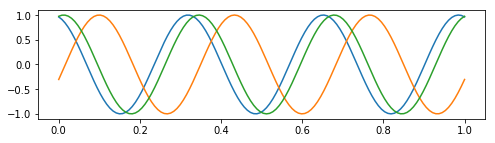

In [3]:
# QC generated data is phase shifted but one frequency
plt.figure(figsize=(8,2))
for i in range(3):
    plt.plot(t,x[np.random.randint(0,nt-1), :])
plt.show()

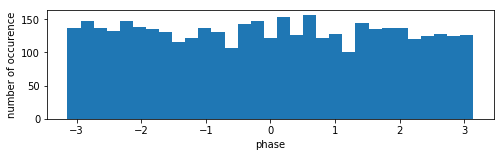

In [4]:
# QC generated phase in [-pi,pi]
plt.figure(figsize=(8,2))
plt.hist(phase,bins=31)
plt.xlabel('phase')
plt.ylabel('number of occurence')
plt.show()

In [5]:
# split into test, validation, and training sets
x_temp, x_test, _, _ = train_test_split(x, x, test_size=0.05)
x_train, x_valid, _, _ = train_test_split(x_temp,
                                          x_temp,
                                          test_size=0.1)
n_train = len(x_train)
n_valid = len(x_valid)
n_test = len(x_test)

In [78]:
# construct autoencoder network structure
activation = 'sigmoid'
encoding_dim = 11

# input layer is full time series of length nt
inputs = Input((nt,))

# add more hidden layers here
encoded = Dense(64, activation='tanh')(inputs) 
encoded = Dense(32, activation='tanh')(encoded)
encoded = Dense(encoding_dim, activation='tanh')(encoded)
decoded = Dense(32, activation='tanh')(encoded)
decoded = Dense(64, activation='tanh')(decoded)


# output layer is same length as input
outputs = Dense(nt, activation='tanh')(decoded)

# consolidate to define autoencoder model inputs and outputs
ae = Model(inputs=inputs, outputs=outputs)

# specify encoder and decoder model for easy encoding and decoding later
encoder = Model(inputs=inputs, outputs=encoded)

In [79]:
print('Full autoencoder')
print(ae.summary())
print('\n Encoder portion of autoencoder')
print(encoder.summary())

Full autoencoder
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 128)               0         
_________________________________________________________________
dense_98 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_99 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_100 (Dense)            (None, 11)                363       
_________________________________________________________________
dense_101 (Dense)            (None, 32)                384       
_________________________________________________________________
dense_102 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_103 (Dense)            (None, 128)               8320

In [80]:
# specify opt. strategy
ae.compile(optimizer='adam',
            loss='mse',
            metrics=['mse'])

In [81]:
# specify training parameters and callback functions

# batch size for stochastic solver  
batch_size = 16

# number of times entire dataset is considered in stochastic solver
epochs = 100

# unique name for the network for saving
unique_name = petname.name()
model_filename = 'aen_sin_%03dHz_n=%05d_'%(int(f),nt)+unique_name+'.h5'

# training history file name
history_filename = 'results_'+unique_name+'.npz'

# stop early after no improvement past epochs=patience and be verbose
earlystopper = EarlyStopping(patience=100, verbose=1)

# checkpoint and save model when improvement occurs 
checkpointer = ModelCheckpoint(model_filename, verbose=1, save_best_only=True)

# consolidate callback functions for convenience 
callbacks = [earlystopper, checkpointer]

In [ ]:
# train autoencoder
results = ae.fit(x_train,x_train,
                  batch_size = batch_size, 
                  epochs = epochs,
                  validation_data = (x_valid,x_valid),
                  callbacks = callbacks)

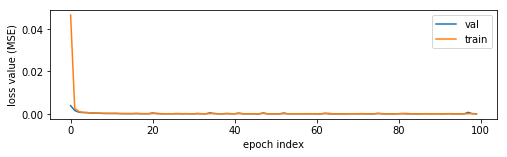

In [107]:
# QC training and validation curves (should follow eachother)
plt.figure(figsize=(8,2))
plt.plot(results.history['val_loss'], label='val')
plt.plot(results.history['loss'], label='train')
plt.xlabel('epoch index')
plt.ylabel('loss value (MSE)')
plt.legend()
plt.show()

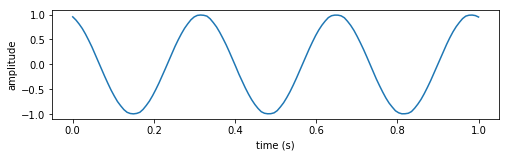

In [108]:
# QC that autoencoder can autoencode a sine wave from the test set
decoded_sin = ae.predict(x_test)
plt.figure(figsize=(8,2))
plt.plot(t,decoded_sin[np.random.randint(0,n_test-1),:])
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.show()

# Showcase denoising properties of autoencoder  
---  
Here is where the fun begins with denoising using autoencoders.  Let's add Gaussian noise with standard devations between one and seven then observe how well the autoencoder denoises.  

Note that we have basically trained nonlinear combination of connected numbers (a network) that collectively excel at encoding and decoding 30 Hz sine waves.

So, we expect a 30 Hz sine wave upon output for a wide variety of inputs through this network.  Recall that the input signal is a sine wave with a peak-to-peak amplitude of 2 - our noise levels are considerably high here.  

(We could improve denoising by including **noisy** sine waves in our training data)  

In [98]:
# specific sine wave index of interest
sin_index = np.random.randint(0,n_test-1)

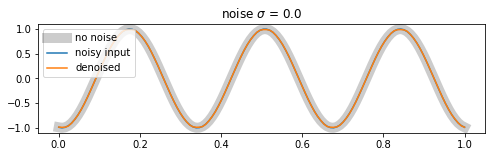

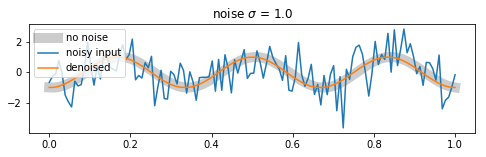

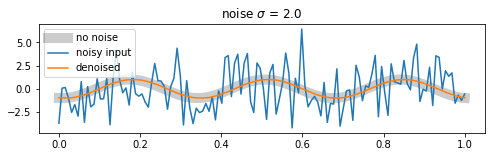

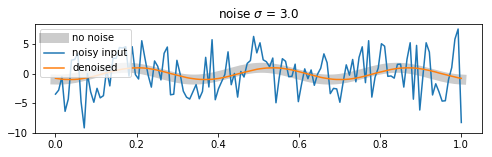

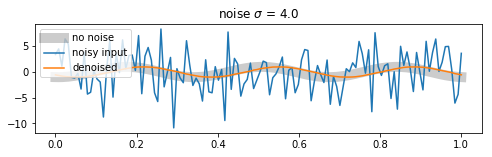

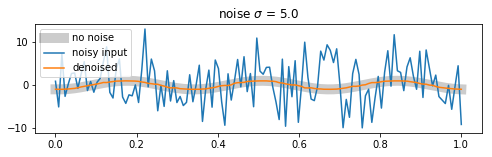

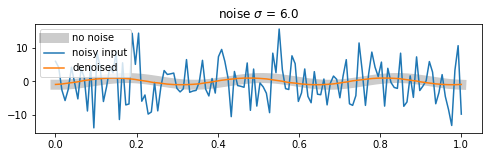

In [104]:
# plot effects of noise on input
for i in range(7):
    plt.figure(figsize=(8,2))
    
    sin_noisy = x_test + np.random.randn(n_test,nt)*i
    decoded_sin = ae.predict(sin_noisy)
    
    plt.plot(t,x_test[sin_index,:], 'k', lw=10, alpha=0.2, label='no noise')
    plt.plot(t, sin_noisy[sin_index,:], label='noisy input')
    plt.plot(t,decoded_sin[sin_index,:], label='denoised')

    plt.title('noise $\sigma$ = %2.1f'%i)
    plt.legend(loc='upper left')
    
    plt.show()
